In [1]:
import numpy as np
import numpy.random as npr
from numpy.random import dirichlet, uniform
from utils import MH_beta, MH_Gaussian
from scipy.stats import beta, norm, bernoulli
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import beta as Beta
from tqdm import tqdm_notebook as tqdm
from scipy.stats import beta
%matplotlib inline

### Parameters

In [2]:
ns = [80, 100, 120]
n = 100
Ms = np.arange(10, 200, step=10)

### Binary data

In [3]:
# compute the KL divergence of beta ditributions with para1 and para2
# KL(beta(para1)||beta(para2))
def KL_dist_beta(para1, para2):
    a1, b1 = para1
    a2, b2 = para2
    sps = npr.beta(a1, b1, 10000)
    itm1 = (a1 - a2) * np.mean(np.log(sps))
    itm2 = (b1 - b2) * np.mean(np.log(1-sps))
    itm3 = - np.log(Beta(a1, b1)/Beta(a2, b2))
    return itm1 + itm2 + itm3 

# compute the Jensen-Shannon Divergence
def JS_dist_beta(para1, para2):
    KL1 = KL_dist_beta(para1, para2)
    KL2 = KL_dist_beta(para2, para1)
    return 0.5* (KL1 + KL2)

In [4]:
# The conditional ESS 
def ESSJS_beta(M, ns, ps, n, p):
    """
    Input:
        M: The amount parameters
        ns: The number of sample size for each historical dataset
        ps: The mean parameters for each historical dataset
        p: The mean parameters for the current dataset
        n: The sample size of the current dataset
    Return:
        The ESS under the UIP-JS method
    
    """
    alps = np.array([nh/n for nh in ns])
    alps[alps>1] = 1
    Ds = [ bernoulli.rvs(ps[i], size=ns[i]) for i in range(len(ns))]
    D = bernoulli.rvs(p, size=n)
    msInv = []
    parasc = [1+np.sum(D), 1+len(D)-np.sum(D)]
    for i, nh in enumerate(ns):
        if nh <= n:
            parash = [1+np.sum(Ds[i]), 1+len(Ds[i])-np.sum(Ds[i])]
            msInv.append(JS_dist_beta(parasc, parash))
        else:
            JSs = []
            for j in range(100):
                Dhc = np.random.choice(Ds[i], size=n, replace=False)
                parashj = [1+np.sum(Dhc), 1+n-np.sum(Dhc)]
                JSs.append(JS_dist_beta(parasc, parashj))
            msInv.append(np.mean(JSs))
    ms = 1/(np.array(msInv)+1e-10)
    ws = ms/ms.sum()
            
            
    phats = np.array([np.mean(Dh) for Dh in Ds])
    mu = np.sum(ws * phats)
    invEta2 = M*np.sum(ws / (1-phats)/phats)
    ESS = mu*(1-mu)*invEta2-1
    return ESS

In [5]:
ps_range = [0.2, 0.8]
p = 0.5
pss = uniform(ps_range[0], ps_range[1], size=(100, 3))

In [6]:
nESSs = []
for ps in tqdm(pss):
    nESS = ESSJS_beta(M=1, ns=ns, ps=ps, n=n, p=p)
    nESSs.append(nESS)
nESSs = np.array(nESSs)

In [7]:
Ms = np.arange(10, 200, step=10)
ESSsM = []
for M in Ms:
    ESSsM.append(np.mean(M*(nESSs + 1) - 1))
ESSsM = np.array(ESSsM)

### ESS for UIP-D

In [8]:
class ESS_UIPD_beta():
    def __init__(self, ns, Ds, n, M, C=100):
        self.ns = np.array(ns)
        self.n = n
        self.M = M
        self.Ds = Ds
        self.C = C
        
        self.thetaBar = None
        self.prior12_sps = None
    
    def prior1_paras(self, wss):
        phats = np.array([np.mean(Dh) for Dh in self.Ds])
        mus = np.sum(wss * phats, axis=1)
        invEta2s = self.M*np.sum(wss / (1-phats)/phats, axis=1)
        alps = mus * (mus*(1-mus)*invEta2s-1)
        bets = (1-mus) * (mus*(1-mus)*invEta2s-1)
        return alps, bets
        
    def _prior1(self, theta, wss):
        alps, bets = self.prior1_paras(wss)
        return beta.pdf(theta, a=alps, b=bets)
        
    
    def _delta_prior1(self, theta, wss):
        alp_deltas, bet_deltas = self.prior1_paras(wss)
        alp_deltas, bet_deltas = alp_deltas/self.C, bet_deltas/self.C
        return beta.pdf(theta, a=alp_deltas, b=bet_deltas)
    
    def delta_prior12(self, theta):
        dalps = self.ns/self.n
        dalps[dalps>=1] = 1
        wss = dirichlet(dalps, size=10000)
        vs = self._delta_prior1(theta, wss)
        return np.mean(vs)
        
    def prior12(self, theta):
        dalps = self.ns/self.n
        dalps[dalps>=1] = 1
        wss = dirichlet(dalps, size=10000)
        vs = self._prior1(theta, wss)
        return np.mean(vs)
    
    def delta_prior12_rvs(self, num):
        sps = MH_beta(n=num, target_density=self.delta_prior12, burnin=5000)
        return sps
    
    def prior12_rvs(self, num):
        sps = MH_beta(n=num, target_density=self.prior12, burnin=5000)
        self.prior12_sps = sps
        return sps
    
    def delta_post12(self, theta, ESS):
        if self.thetaBar is None:
            if self.prior12_sps is None:
                self.prior12_rvs(1000)
            self.thetaBar = np.mean(self.prior12_sps)
        logItm1 = np.log(self.delta_prior12(theta))
        logItm2 = ESS*self.thetaBar*np.log(theta)
        logItm3 = ESS*(1-self.thetaBar)*np.log(1-theta)
        logDen = logItm1 + logItm2 + logItm3
        #print(theta)
        return np.exp(logDen)
    
    def delta_post12_rvs(self, num, ESS):
        def tdensity(theta):
            #print(self.delta_post12(theta, ESS))
            return self.delta_post12(theta, ESS)
        sps = MH_beta(n=num, target_density=tdensity, burnin=5000)
        return sps
        

In [61]:
Ds = [ bernoulli.rvs(ps[i], size=ns[i]) for i in range(len(ns))]

In [62]:
ESSUIPD = ESS_UIPD_beta(ns=ns, Ds=Ds, n=n, M=100)

In [63]:
prior_sps = ESSUIPD.prior12_rvs(1000)

In [64]:
post_sps = ESSUIPD.delta_post12_rvs(1000, ESS=10)

In [66]:
post_sps100 = ESSUIPD.delta_post12_rvs(1000, ESS=100)

In [69]:
1/np.var(prior_sps) - 1/np.var(post_sps)

5.031866658589671

In [70]:
1/np.var(prior_sps) - 1/np.var(post_sps100)

-405.9351573562526

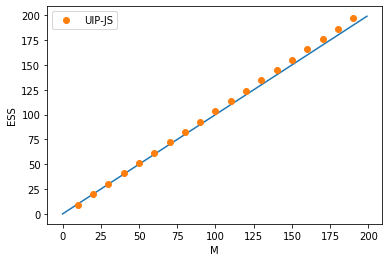

In [137]:
plt.plot(np.arange(200), np.arange(200))
plt.plot(Ms, ESSsM, "o", label="UIP-JS")
plt.legend()
plt.xlabel("M")
_ = plt.ylabel("ESS")